In [1]:
# Clone the ibm/tsfm
! git clone https://github.com/IBM/tsfm.git

Cloning into 'tsfm'...
remote: Enumerating objects: 2569, done.
remote: Counting objects: 100% (1116/1116), done.
remote: Compressing objects: 100% (417/417), done.
remote: Total 2569 (delta 760), reused 802 (delta 682), pack-reused 1453 (from 1)
Receiving objects: 100% (2569/2569), 23.37 MiB | 21.67 MiB/s, done.
Resolving deltas: 100% (1505/1505), done.


In [2]:
# Change directory. Move inside the tsfm repo.
%cd tsfm

/content/tsfm


In [3]:
# Install the tsfm library
! pip install ".[notebooks]"

Processing /content/tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.9 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 k

In [4]:
import math
import os
import tempfile

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import TinyTimeMixerForPrediction, TrackingCallback, count_parameters, load_dataset
from tsfm_public.toolkit.visualization import plot_predictions

In [5]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [180]:
import pandas as pd
import yfinance as yf

# Define the ticker symbol for Apple
ticker = "AAPL"

# Fetch the data for the relevant period with hourly intervals
apple_stock_data = yf.download(
    ticker,
    start="2022-09-01",
    end="2023-12-31",
    interval="60m"  # 60m for hourly data
)

# Reset the index to have the timestamp as a column
apple_stock_data.reset_index(inplace=True)

# Ensure the data is sorted by the timestamp
apple_stock_data = apple_stock_data.sort_values(by='Datetime')

# Specify the prediction date for context length 512
prediction_start_date = pd.Timestamp('2023-04-19T09:30:00')

# Filter the data to include only records before the prediction start date
filtered_data = apple_stock_data[apple_stock_data['Datetime'] < prediction_start_date]

# Check if there are enough data points
if len(filtered_data) < 1024:
    raise ValueError("Not enough data points available before the prediction start date.")

# Get the start date by selecting the row at the position `-1024`
context_start_date = filtered_data.iloc[-1024]['Datetime']

print("Context start date for context length 1024:", context_start_date)
apple_stock_data = apple_stock_data[apple_stock_data['Datetime'] >= context_start_date]

# Reset the index for further processing
apple_stock_data.reset_index(drop=True, inplace=True)

# Display the first few rows to confirm the data
print(apple_stock_data.head())


[*********************100%***********************]  1 of 1 completed

Context start date for context length 1024: 2022-09-16 10:30:00
             Datetime        Open        High         Low       Close  \
0 2022-09-16 10:30:00  149.449997  150.529999  148.729996  149.139999   
1 2022-09-16 11:30:00  149.139999  149.960007  148.660004  148.767807   
2 2022-09-16 12:30:00  148.764999  149.509995  148.720001  149.279999   
3 2022-09-16 13:30:00  149.279999  150.259995  149.149994  150.149994   
4 2022-09-16 14:30:00  150.154999  151.350006  149.929993  150.770004   

    Adj Close    Volume  
0  149.139999  14749521  
1  148.767807   9088989  
2  149.279999   7358627  
3  150.149994   9528447  
4  150.770004  12344001  


In [181]:
# Select the relevant columns and rename 'Datetime' to 'timestamp'
apple_stock_data = apple_stock_data[['Datetime', 'Close']]
apple_stock_data.rename(columns={'Datetime': 'timestamp', 'Close': 'close'}, inplace=True)

# Normalize the 'close' prices
# apple_stock_data['close'] = (apple_stock_data['close'] - apple_stock_data['close'].mean()) / apple_stock_data['close'].std()

# Save the processed data to a CSV file
apple_stock_data.to_csv('/content/apple_stock_2023_hourly.csv', index=False)

# Display the first few rows to verify the data
print(apple_stock_data.head())


            timestamp       close
0 2022-09-16 10:30:00  149.139999
1 2022-09-16 11:30:00  148.767807
2 2022-09-16 12:30:00  149.279999
3 2022-09-16 13:30:00  150.149994
4 2022-09-16 14:30:00  150.770004


In [182]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

forecast_length=96
context_length=1024
target_dataset = "apple_stock_2023_hourly"
DATA_ROOT_PATH = "/content/"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "1024_96_v1"

In [183]:
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor


In [184]:
len(apple_stock_data),

(2255,)

In [185]:

    timestamp_column = "timestamp"
    id_columns = []
    target_columns = ["close"]
    split_config = {
                      "train": [  0,
                       len(apple_stock_data),],
                "valid": [  0,
                       len(apple_stock_data),],
                    "test": [
                        0,
                       len(apple_stock_data),
                    ],
                }
    # Understanding the split config -- slides

    data = pd.read_csv(
        '/content/apple_stock_2023_hourly.csv',
        parse_dates=[timestamp_column],
    )

    column_specifiers = {
        "timestamp_column": timestamp_column,
        "id_columns": id_columns,
        "target_columns": target_columns,
        "control_columns": [],
    }

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        # scaling=True,
        encode_categorical=False,
        # scaler_type=None,
    )

    train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
        data, split_config, fewshot_fraction=1, fewshot_location="first"
    )

In [186]:
 zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION
        )

In [196]:
train_dataset[1]

{'past_values': tensor([[148.7678],
         [149.2800],
         [150.1500],
         ...,
         [166.3800],
         [166.4414],
         [166.6400]]),
 'future_values': tensor([[167.1423],
         [167.8150],
         [167.9200],
         [167.9000],
         [167.7700],
         [167.6200],
         [167.0400],
         [167.1400],
         [167.4100],
         [167.6009],
         [166.8700],
         [165.6200],
         [166.6506],
         [165.3798],
         [165.0900],
         [164.9291],
         [164.7975],
         [165.2750],
         [164.9575],
         [165.0200],
         [165.2988],
         [164.1800],
         [164.3400],
         [164.7800],
         [165.1722],
         [165.3450],
         [165.3500],
         [165.3400],
         [165.2200],
         [164.6313],
         [164.3400],
         [164.3206],
         [164.1200],
         [163.8000],
         [163.3106],
         [164.6200],
         [165.0300],
         [164.1800],
         [163.7600],
       

In [188]:
output = zeroshot_model.forward(train_dataset[0]["past_values"].unsqueeze(0), return_loss=False)
output.prediction_outputs.shape

torch.Size([1, 96, 1])

In [189]:
output

TinyTimeMixerForPredictionOutput(loss=None, prediction_outputs=tensor([[[166.7043],
         [166.7541],
         [166.2068],
         [166.1931],
         [165.8624],
         [165.8544],
         [165.6708],
         [165.6075],
         [165.5059],
         [165.4494],
         [165.3223],
         [165.2456],
         [165.4318],
         [165.2910],
         [165.3470],
         [165.3996],
         [165.4088],
         [165.2969],
         [165.2197],
         [165.1653],
         [164.9901],
         [164.9152],
         [164.7873],
         [164.6242],
         [164.6788],
         [165.0172],
         [164.8714],
         [164.9562],
         [164.6357],
         [164.3673],
         [164.3935],
         [164.4517],
         [164.3736],
         [164.6213],
         [164.5835],
         [164.5957],
         [164.5276],
         [164.4147],
         [164.1116],
         [164.0136],
         [163.8521],
         [163.9505],
         [163.7311],
         [163.9785],
         [163

In [198]:
from torch.utils.data import Subset

# Create a subset of the dataset starting from the second item
train_dataset = Subset(train_dataset, range(1, len(train_dataset)))


In [200]:
train_dataset[0]

{'past_values': tensor([[148.7678],
         [149.2800],
         [150.1500],
         ...,
         [166.3800],
         [166.4414],
         [166.6400]]),
 'future_values': tensor([[167.1423],
         [167.8150],
         [167.9200],
         [167.9000],
         [167.7700],
         [167.6200],
         [167.0400],
         [167.1400],
         [167.4100],
         [167.6009],
         [166.8700],
         [165.6200],
         [166.6506],
         [165.3798],
         [165.0900],
         [164.9291],
         [164.7975],
         [165.2750],
         [164.9575],
         [165.0200],
         [165.2988],
         [164.1800],
         [164.3400],
         [164.7800],
         [165.1722],
         [165.3450],
         [165.3500],
         [165.3400],
         [165.2200],
         [164.6313],
         [164.3400],
         [164.3206],
         [164.1200],
         [163.8000],
         [163.3106],
         [164.6200],
         [165.0300],
         [164.1800],
         [163.7600],
       

In [201]:
import pandas as pd

# Initialize an empty list to store results
results = []

# Loop through each data point in the training dataset
for i, data_point in enumerate(train_dataset):
    # Extract past values, actual future values, and the prediction timestamp
    past_values = data_point["past_values"]
    actual_values = data_point["future_values"]
    timestamp = data_point["timestamp"]

    # Forward pass through the model
    output = zeroshot_model.forward(past_values.unsqueeze(0), return_loss=False)

    # Extract the predicted values
    predicted_values = output.prediction_outputs.squeeze(0).tolist()  # Convert to list

    # Convert actual values to list
    actual_values_list = actual_values.squeeze(0).tolist()  # Ensure it's a list

    # Collect data for each prediction
    result = {
        "start_past_values": past_values[0].item(),
        "end_past_values": past_values[-1].item(),
        "prediction_date": timestamp,  # Store the timestamp of the prediction
        "predicted_values": predicted_values,  # Store all predicted values as a list
        "actual_values": actual_values_list  # Store all actual values as a list
    }

    results.append(result)

# Convert results into a DataFrame
results_df = pd.DataFrame(results)




In [202]:
results_df

,start_past_values,end_past_values,prediction_date,predicted_values,actual_values
0,148.767807,166.639999,2023-04-19 09:30:00,"[[166.92538452148438], [166.92568969726562], [...","[[167.14230346679688], [167.81500244140625], [..."
1,149.279999,167.142303,2023-04-19 10:30:00,"[[167.418701171875], [167.29759216308594], [16...","[[167.81500244140625], [167.9199981689453], [1..."
2,150.149994,167.815002,2023-04-19 11:30:00,"[[168.17724609375], [168.05389404296875], [167...","[[167.9199981689453], [167.89999389648438], [1..."
3,150.770004,167.919998,2023-04-19 12:30:00,"[[168.3041534423828], [168.11260986328125], [1...","[[167.89999389648438], [167.77000427246094], [..."
4,150.440002,167.899994,2023-04-19 13:30:00,"[[168.32284545898438], [168.1801300048828], [1...","[[167.77000427246094], [167.6199951171875], [1..."
...,...,...,...,...,...
1130,173.177505,195.714996,2023-12-08 13:30:00,"[[195.35098266601562], [195.33761596679688], [...","[[195.74000549316406], [195.72000122070312], [..."
1131,172.029999,195.740005,2023-12-08 14:30:00,"[[195.48519897460938], [195.46353149414062], [...","[[195.72000122070312], [192.11000061035156], [..."
1132,172.619995,195.720001,2023-12-08 15:30:00,"[[195.57464599609375], [195.56227111816406], [...","[[192.11000061035156], [191.80999755859375], [..."
1133,173.630005,192.110001,2023-12-11 09:30:00,"[[191.03582763671875], [191.27122497558594], [...","[[191.80999755859375], [192.10000610351562], [..."


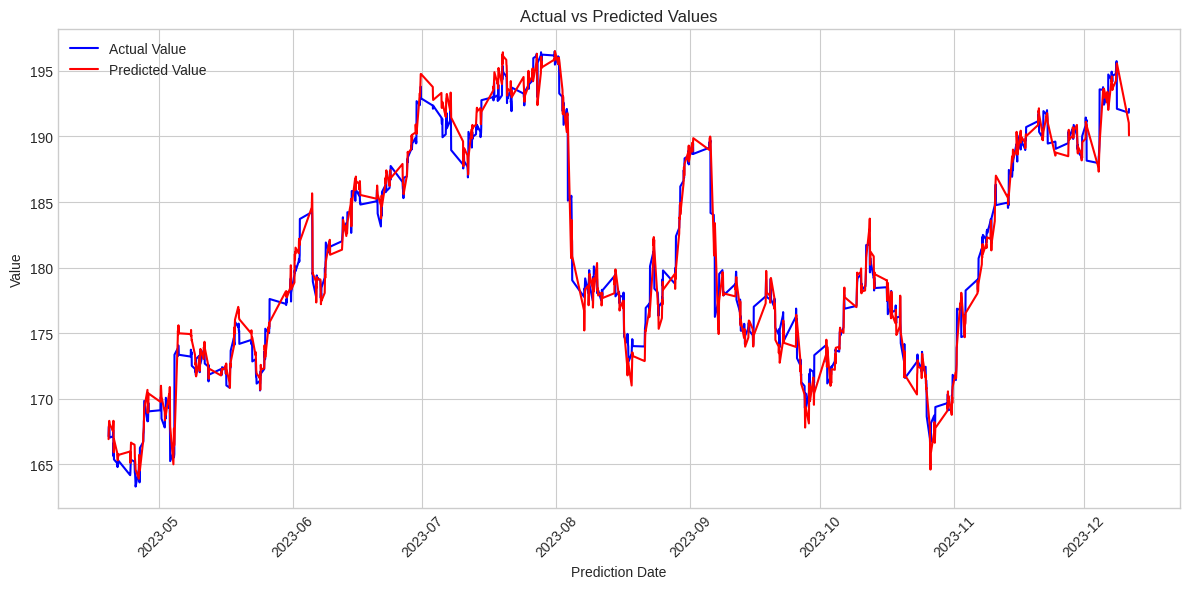

In [204]:
import matplotlib.pyplot as plt

# Extract the first predicted and first actual values along with the prediction dates
prediction_dates = results_df['prediction_date']
first_predicted_values = [pred[0] for pred in results_df['predicted_values']]
first_actual_values = [actual[0] for actual in results_df['actual_values']]

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the actual values
plt.plot(prediction_dates, first_actual_values, label='Actual Value', color='blue', )

# Plot the predicted values
plt.plot(prediction_dates, first_predicted_values, label='Predicted Value', color='red',)

# Adding title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Prediction Date')
plt.ylabel('Value')

# Add a legend
plt.legend()

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [205]:
results_df['first_predicted_value'] = results_df['predicted_values'].apply(lambda x: x[0][0])
results_df['first_actual_value'] = results_df['actual_values'].apply(lambda x: x[0][0])

# Create a new DataFrame with the necessary columns
context_results_df = pd.DataFrame({
    'y_actual': results_df['first_actual_value'],
    'raw_forecast': results_df['first_predicted_value'],
    'prediction_date': results_df['prediction_date']
})
context_results_df

,y_actual,raw_forecast,prediction_date
0,167.142303,166.925385,2023-04-19 09:30:00
1,167.815002,167.418701,2023-04-19 10:30:00
2,167.919998,168.177246,2023-04-19 11:30:00
3,167.899994,168.304153,2023-04-19 12:30:00
4,167.770004,168.322845,2023-04-19 13:30:00
...,...,...,...
1130,195.740005,195.350983,2023-12-08 13:30:00
1131,195.720001,195.485199,2023-12-08 14:30:00
1132,192.110001,195.574646,2023-12-08 15:30:00
1133,191.809998,191.035828,2023-12-11 09:30:00


In [206]:
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score


# Define the calculation functions (same as before)
def calculate_mse(context_results_df):
    return mean_squared_error(context_results_df['y_actual'], context_results_df['raw_forecast'])

def calculate_accuracy(context_results_df):
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(context_results_df)):
        actual_today = context_results_df['y_actual'].iloc[i]
        predicted_today = context_results_df['raw_forecast'].iloc[i]
        actual_yesterday = context_results_df['y_actual'].iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1

    return correct_predictions / total_predictions if total_predictions > 0 else 0

def calculate_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(1, len(context_results_df)):
        today_price = context_results_df['y_actual'].iloc[i]
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_actual_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['raw_forecast'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(2, len(context_results_df)):
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        yesterday_predicted_today_price = context_results_df['raw_forecast'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_results_for_context_len(context_len, context_results_df):
    # Use the provided DataFrame directly
    mse_value = calculate_mse(context_results_df)
    accuracy_value = calculate_accuracy(context_results_df)
    profit = calculate_profit(context_results_df)
    direction_accuracy = calculate_direction_accuracy(context_results_df)
    actual_direction_accuracy = calculate_actual_direction_accuracy(context_results_df)
    direction_profit = calculate_direction_profit(context_results_df)

    # Compile the results into a DataFrame
    result = {
        'context_len': context_len,
        'mse': mse_value,
        'accuracy': accuracy_value,
        'direction_accuracy': direction_accuracy,
        'actual_direction_accuracy': actual_direction_accuracy,
        'direction_profit': direction_profit,
        'profit': profit
    }

    return pd.DataFrame([result])

# Calculate the results for the provided context_results_df
final_result_df = calculate_results_for_context_len(context_length, context_results_df)
print(final_result_df)


   context_len       mse  accuracy  direction_accuracy  \
0         1024  1.153535  0.492063              0.5194   

   actual_direction_accuracy  direction_profit     profit  
0                   0.492063         19.896723  11.406432  


In [207]:
def calculate_buy_and_hold_profit(context_results_df, initial_capital=100):
    """
    Calculate the profit from a buy-and-hold strategy.

    Args:
    - context_results_df (DataFrame): DataFrame containing actual prices.
    - initial_capital (float): The starting amount of money.

    Returns:
    - float: The profit from a buy-and-hold strategy.
    """
    # Buy at the first available price
    first_price = context_results_df['y_actual'].iloc[0]

    # Sell at the last available price
    last_price = context_results_df['y_actual'].iloc[-1]

    # Calculate the number of shares bought initially
    shares = initial_capital / first_price

    # Final capital after selling all shares at the last price
    final_capital = shares * last_price

    # Profit is the final capital minus the initial capital
    profit = final_capital - initial_capital

    return profit

# Assuming `context_results_df` is already prepared as in the previous code
buy_and_hold_profit = calculate_buy_and_hold_profit(context_results_df)
print(f"Buy and Hold Profit: {buy_and_hold_profit}")


Buy and Hold Profit: 14.932008306129774
